<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v14_oscillatingGradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v14: Oscillating Gradients
Re-starts work done much earlier into visualising oscillating gradients.

Background:
* Oscillating gradients is another of the common problems. The usual recommended tactic is to notice when the loss is oscillating and to reduce the learning rate. But I've seen that the loss can oscillate at the level of each step, but get smoothed out at the epoch level so that you loose a key signal.
* Furthermore, oscillations are actually a normal behaviour, with smaller oscillations occurring around some running average without crossing the zero-line.
* There's some fascinating ideas about looking at rapid angle changes when treating a layer's gradients as a single high-dimensional vector, but they always run into problems.

Common difficulties with trying to measure gradient oscillations:
* Often the oscillations don't occur within a single step, but are smooth cycles over multiple steps. You can't just compare the immediately previous timestep to the current, you have to compare peak-to-peak changes. Now you have the difficulty of defining discrete peaks.
* Magnitude matters. Frequent sign changes on gradients that are already close to zero should be ignored. While sign changes on large gradients should be alerted on.

Key idea:
* A simpler solution that avoids most of the issues (at the cost of one other issue) is to simply measure the percentage of values that are positive for a given tensor.
* This suffers from false-negatives if an equal number of values switch from positive to negative as do from negative to positive. But, in practice, that particular concern is probably rare.

In [140]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout 57a6d83
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at 57a6d83 Bug fixes when less callbacks in use
HEAD is now at 57a6d83 Bug fixes when less callbacks in use


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [8]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [9]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basics


In [11]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

# tip: model above uses steps-per-epoch=10
def mean_per_window(tensor, window_size=10):
  # trim last rows to ensure length divisible by window_size
  if tensor.shape[0] % window_size > 0:
    tensor = tensor[:-(tensor.shape[0] % window_size)]
  # group and compute means
  new_shape = (tensor.shape[0] // window_size, window_size) + tensor.shape[1:]
  return np.mean(tensor.reshape(new_shape), axis=1)

def plot_correlation_trends(data, mean_window_size=None, title="Correlation Between Consecutive Training Iterations"):
  data = data.reshape(data.shape[0], -1)
  step = data.shape[0]  # Number of training steps

  # Compute correlation between consecutive steps
  # using: from scipy.stats import pearsonr
  correlations = [pearsonr(data[i], data[i + 1])[0] for i in range(step - 1)]

  # Convert to NumPy array for further analysis
  correlations = np.array(correlations)
  if mean_window_size is not None:
    correlations = mean_per_window(correlations, window_size=mean_window_size)

  # Plot correlation trends over iterations
  plt.figure(figsize=(8, 5))
  plt.plot(correlations, alpha=0.7)
  plt.xlabel("Iteration")
  plt.ylabel("Correlation (t -> t+1)")
  plt.title(title)
  plt.grid(True)
  plt.ylim([-1., 1.])
  plt.show()


# Data collection from basic model
We're going to take advantage of the fact that it's now easy to collect raw gradients etc. from an entire training run.

In [ ]:
train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [15]:
reload(tot)
tf.config.run_functions_eagerly(False)

# collect data for all layers and all trainable variables
collection_sets=[{}]

variables = tot.VariableHistoryCallback(per_step=True, collection_sets=collection_sets)
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=collection_sets)
outputs = tot.LayerOutputHistoryCallback(per_step=True, collection_sets=collection_sets)
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=collection_sets)

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, outputs, output_gradients, tot.HistoryStats(per_step=True)])

Epoch    10 - 2.16s/epoch: accuracy: 0.7300  binary_crossentropy: 0.5657  loss: 0.5657  mse: 0.1896  
Epoch    20 - 863.86ms/epoch: accuracy: 0.8033  binary_crossentropy: 0.4658  loss: 0.4658  mse: 0.1498  
Epoch    30 - 754.98ms/epoch: accuracy: 0.8567  binary_crossentropy: 0.3827  loss: 0.3827  mse: 0.1193  
Epoch    40 - 801.12ms/epoch: accuracy: 0.8400  binary_crossentropy: 0.3389  loss: 0.3389  mse: 0.1055  
Epoch    50 - 944.34ms/epoch: accuracy: 0.8833  binary_crossentropy: 0.3158  loss: 0.3158  mse: 0.0929  
Epoch    60 - 622.20ms/epoch: accuracy: 0.8967  binary_crossentropy: 0.2261  loss: 0.2261  mse: 0.0701  
Epoch    70 - 915.91ms/epoch: accuracy: 0.9167  binary_crossentropy: 0.2008  loss: 0.2008  mse: 0.0597  
Epoch    80 - 1.04s/epoch: accuracy: 0.9400  binary_crossentropy: 0.1594  loss: 0.1594  mse: 0.0439  
Epoch    90 - 686.95ms/epoch: accuracy: 0.9367  binary_crossentropy: 0.1564  loss: 0.1564  mse: 0.0448  
Epoch   100 - 822.02ms/epoch: accuracy: 0.9600  binary_crosse

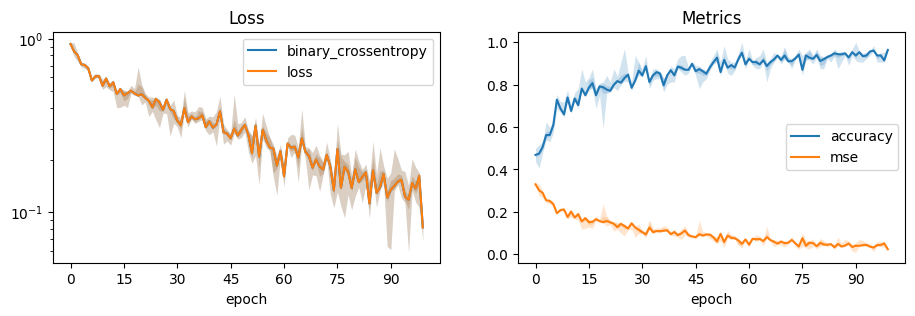

In [16]:
tot.plot_train_history(history)

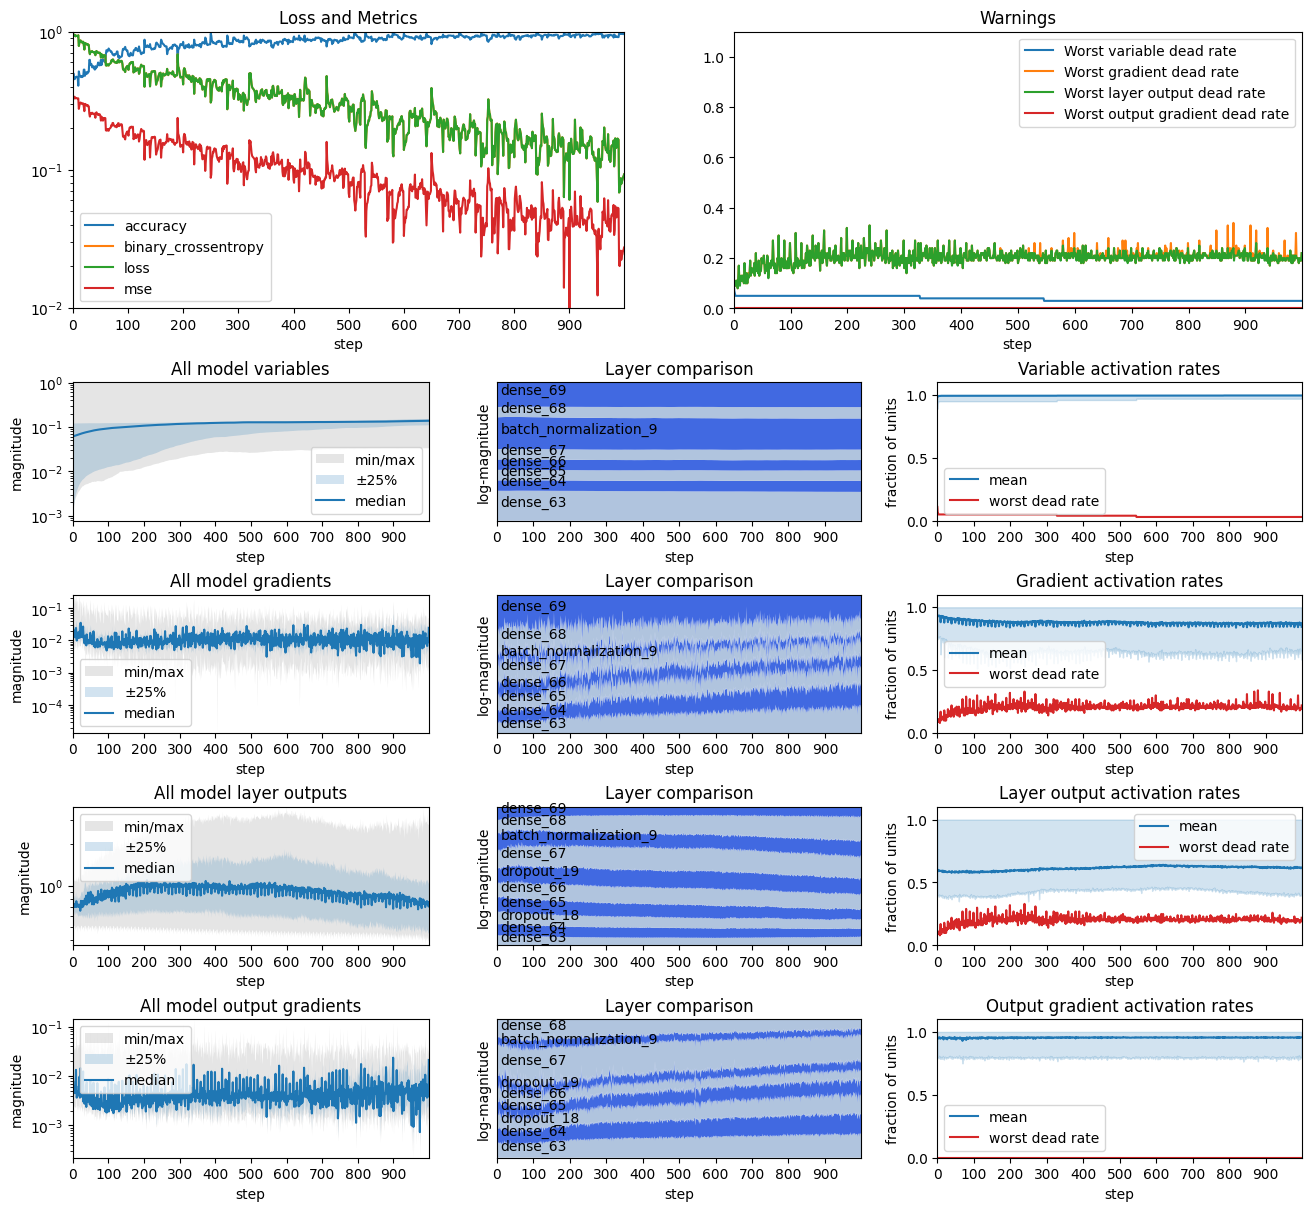

In [17]:
tot.plot_history_overview([history, variables, gradients, outputs, output_gradients])

## Gradient oscillation analysis
We'll focus on the gradients of the weights.
In practice the tools we're about to develop could be used against any of the collected values.

In [26]:
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
type(gradients.gradients[var_indices[0]][0])
layer_grads = np.stack(gradients.gradients[var_indices[0]], axis=0)
layer_grads.shape

In [43]:
# Use entire training period to define a 10th-percentile bound,
# we'll use this to split values into positive, negative, and near-zero, and then ignore near-zero values.
# Do on per-value basis.
near_zero_threshold = np.percentile(np.abs(layer_grads), 50, axis=0)
near_zero_threshold.shape

(100, 100)

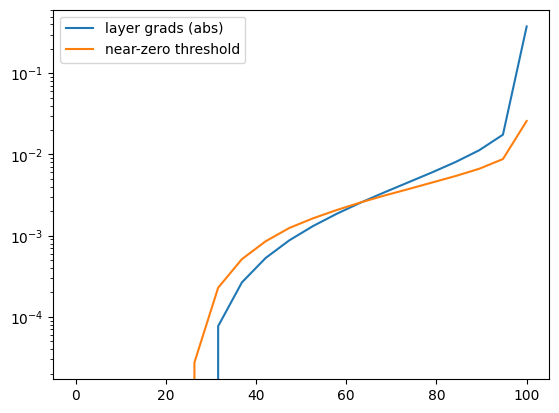

In [52]:
q = np.linspace(0, 100, 20)
plt.plot(q, np.percentile(abs(layer_grads), q), label='layer grads (abs)')
plt.plot(q, np.percentile(near_zero_threshold, q), label='near-zero threshold')
plt.legend()
plt.yscale('log')
plt.show()

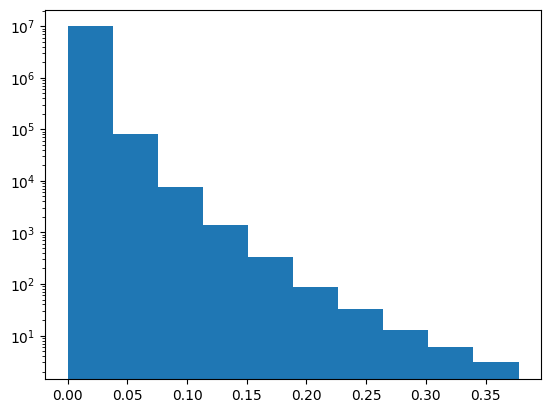

In [56]:
plt.hist(abs(layer_grads.flatten()))
plt.yscale('log')
plt.show()

array([0.00000000e+00, 5.89799420e-07, 1.45236225e-03, 3.89937448e-03,
       2.58819442e-02])

In [44]:
pos = (layer_grads > near_zero_threshold).astype(np.float32)
neg = (layer_grads < -near_zero_threshold).astype(np.float32)
rates = np.sum(pos, axis=(1,2)) / np.sum(pos + neg, axis=(1,2))
rates.shape

(1000,)

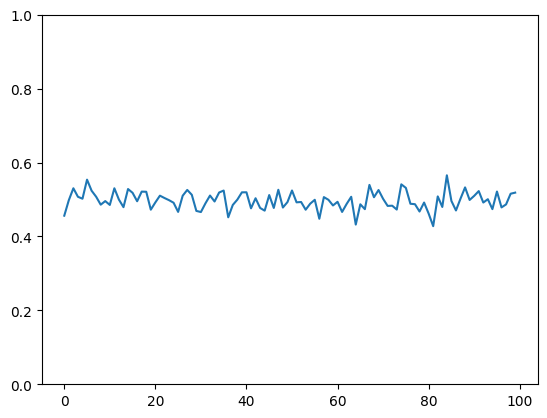

In [45]:
plt.plot(rates[0:100])
plt.ylim([0., 1.])
plt.show()

## Coefficents
The following paper uses correlation coefficients from iteration-to-iteration. Let's try that on the gradient data.

Morchdi, C., Zhou, Y., Ding, J., & Wang, B. (2023). Exploring Gradient Oscillation in Deep Neural Network Training. 59th Annual Allerton Conference on Communication, Control, and Computing (Allerton, USA).
* https://www.sci.utah.edu/~beiwang/publications/Mysterious_BeiWang_2023.pdf


In [83]:
layer_idx = 8
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)

print(f"before: {data.shape}")
print(f"after: {mean_per_window(data).shape}")

before: (1000, 100, 5)
after: (100, 100, 5)


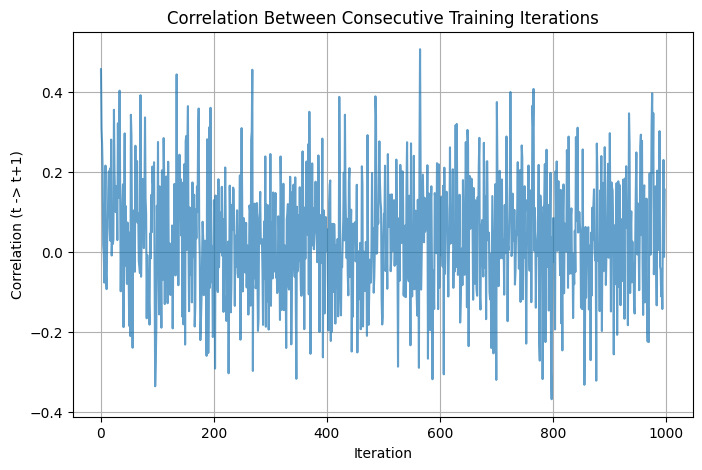

In [82]:
layer_idx = 8
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = data.reshape(data.shape[0], -1)
#data = mean_per_window(data, window_size=10) # optional: convert to per-epoch
plot_correlation_trends(data)

## PCA
From some reading, one way of visualising gradient descent is to run PCA over the variables and plot their movement as a 2D plot.

Inspiration:
* Visualizing the Loss Landscape of Neural Nets. NIPS 2018.
* https://arxiv.org/abs/1712.09913


In [62]:
model.layers

[<Dense name=dense_63, built=True>,
 <Dense name=dense_64, built=True>,
 <Dropout name=dropout_18, built=True>,
 <Dense name=dense_65, built=True>,
 <Dense name=dense_66, built=True>,
 <Dropout name=dropout_19, built=True>,
 <Dense name=dense_67, built=True>,
 <BatchNormalization name=batch_normalization_9, built=True>,
 <Dense name=dense_68, built=True>,
 <Dense name=dense_69, built=True>]

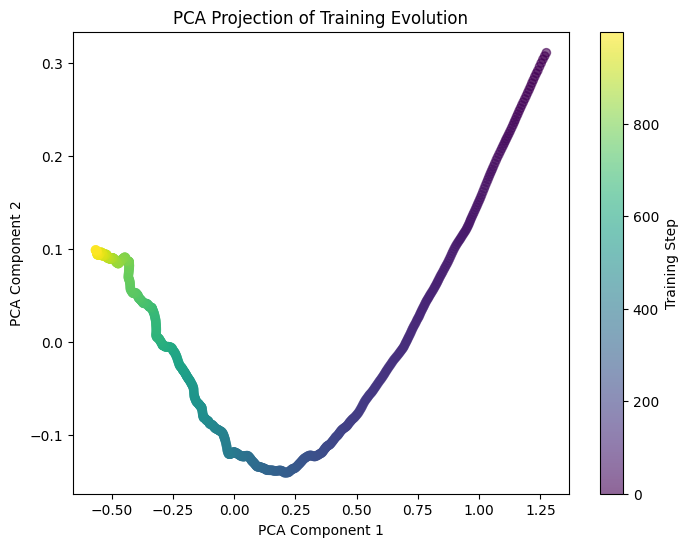

In [71]:
layer_idx = 8
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(variables.variables[var_indices[0]], axis=0)
step = data.shape[0]
data = data.reshape(data.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2D
transformed_data = pca.fit_transform(data)  # (step, 2)

# Plot the 2D projection of training steps
plt.figure(figsize=(8, 6))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=np.arange(step), cmap='viridis', alpha=0.6)
plt.colorbar(label="Training Step")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Training Evolution")
plt.show()


What if we also did the same for the gradients themselves?

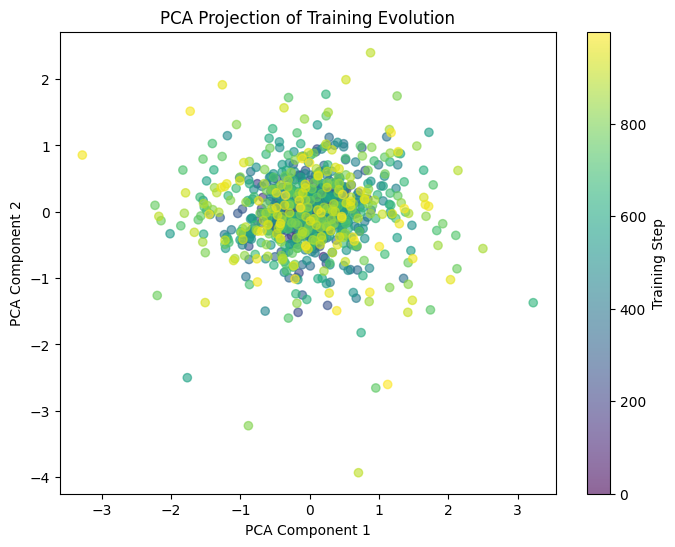

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

layer_idx = 1
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
step = data.shape[0]  # Number of training steps
data = data.reshape(data.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2D
transformed_data = pca.fit_transform(data)  # (step, 2)

# Plot the 2D projection of training steps
plt.figure(figsize=(8, 6))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=np.arange(step), cmap='viridis', alpha=0.6)
plt.colorbar(label="Training Step")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Training Evolution")
plt.show()

## Experimenting with other models for gradient-coefficient analysis


In [21]:
def mnist_linear_classifier_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

train_X, train_Y = mnist_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}")

train_X: (60000, 28, 28), train_Y: (60000,)


In [5]:
# Model training
reload(tot)

# collect data for all layers and all trainable variables
collection_sets=[{}]

per_step=False
gradients = tot.GradientHistoryCallback(per_step=per_step, collection_sets=collection_sets)

start = tf.timestamp()
model = mnist_linear_classifier_model()
train_X, train_Y = mnist_dataset()
if per_step:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(1000).batch(64)
  history = tot.fit(model, dataset, epochs=10, verbose=0, callbacks=[gradients, tot.HistoryStats(per_step=per_step), tot.LessVerboseProgressLogger()])
else:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
  history = tot.fit(model, dataset, epochs=10, verbose=0, callbacks=[gradients, tot.HistoryStats(per_step=per_step), tot.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7644 - loss: 0.8867
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9051 - loss: 0.3422
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9144 - loss: 0.3046
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9188 - loss: 0.2882
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9217 - loss: 0.2785
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9232 - loss: 0.2719
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9248 - loss: 0.2670
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9257 - loss: 0.2632
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9267 - loss: 0.2601
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9278 - loss: 0.2575
Total training time: 38.46 secs


AttributeError: 'NoneType' object has no attribute 'model'

grid_height=3, grid_width=6, 0


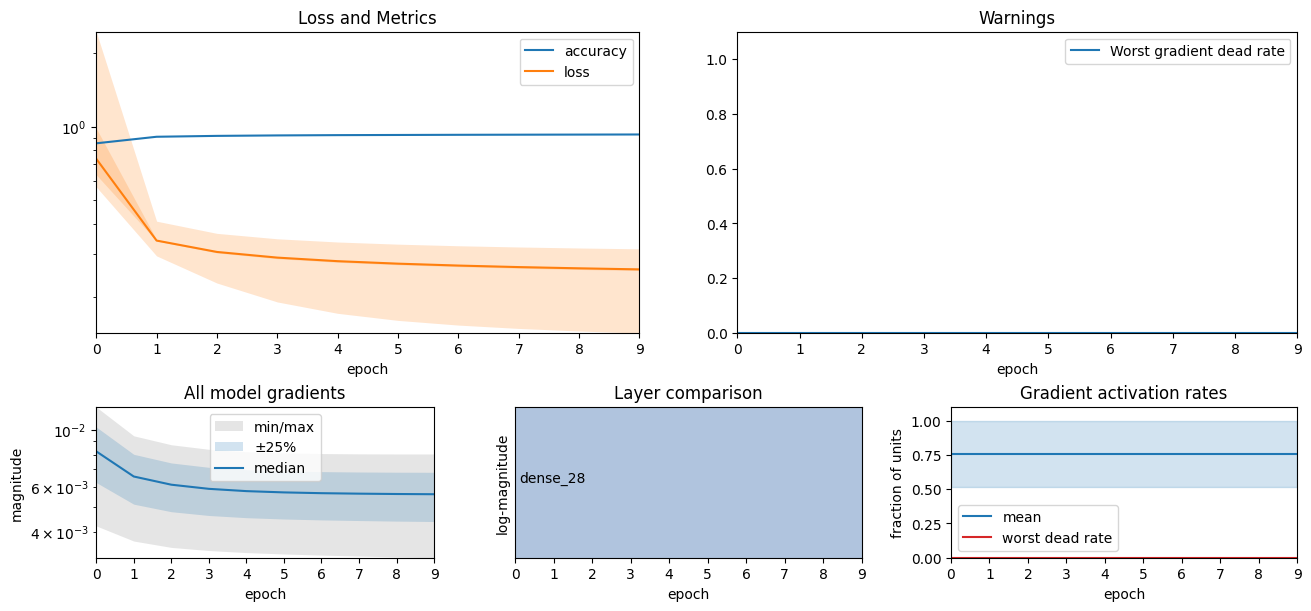

In [10]:
reload(tot)
tot.plot_history_overview(callbacks=[gradients, history])

In [12]:
model.variables

[<Variable path=sequential_4/dense_28/kernel, shape=(784, 10), dtype=float32, value=[[ 0.03226831  0.03798507 -0.04453247 ...  0.06147388  0.0670081
    0.0223554 ]
  [ 0.07626165 -0.06098891  0.08627938 ... -0.02938265 -0.00991517
    0.04483456]
  [-0.05131454  0.08200777 -0.0190544  ...  0.03176375  0.03465056
   -0.02171599]
  ...
  [ 0.03873963 -0.06593379 -0.02461736 ...  0.06040298  0.04877096
   -0.07811009]
  [-0.01959961  0.07550346 -0.0297709  ... -0.05965938 -0.04199051
    0.02735955]
  [ 0.03680515 -0.0179917   0.05034801 ...  0.00258934 -0.04231115
   -0.03625445]]>,
 <Variable path=sequential_4/dense_28/bias, shape=(10,), dtype=float32, value=[-0.42549014  0.57309425  0.09351471 -0.3649611   0.10656343  1.1036756
  -0.11945107  0.60640836 -1.196645   -0.22898415]>]

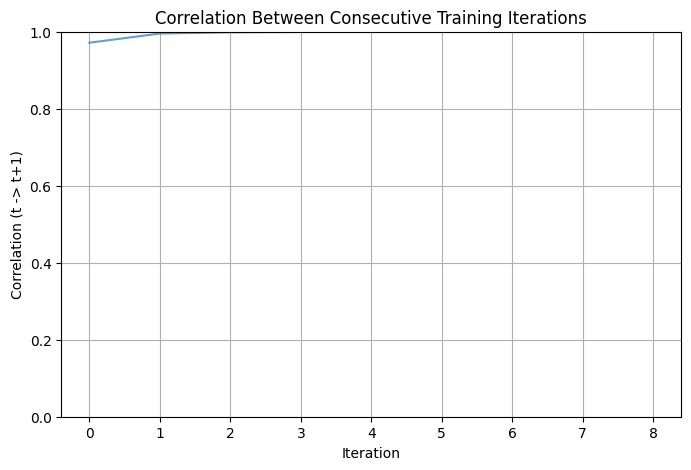

In [18]:
data = np.stack(gradients.gradients[0], axis=0)
#data = mean_per_window(data, window_size=10) # optional: convert to per-epoch
plot_correlation_trends(data)

In [12]:
# Simple CNN
def mnist_simple_cnn_model(learning_rate):
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model


In [13]:
# Simple CNN on MNIST with high learning rate
collection_sets=[{}]
per_step=True
gradients = tot.GradientHistoryCallback(per_step=per_step, collection_sets=collection_sets)

start = tf.timestamp()
model = mnist_simple_cnn_model(learning_rate=0.1)
train_X, train_Y = mnist_dataset()
if per_step:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(10000).batch(64)
  history = tot.fit(model, dataset, epochs=100, verbose=0, callbacks=[gradients, tot.HistoryStats(per_step=per_step), tot.LessVerboseProgressLogger()])
else:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
  history = tot.fit(model, dataset, epochs=100, verbose=0, callbacks=[gradients, tot.HistoryStats(per_step=per_step), tot.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 1.77s/epoch: accuracy: 0.9799  loss: 0.0702  
Epoch    20 - 1.41s/epoch: accuracy: 0.9952  loss: 0.0183  
Epoch    30 - 1.41s/epoch: accuracy: 0.9929  loss: 0.0200  
Epoch    40 - 1.55s/epoch: accuracy: 1.0000  loss: 0.0007  
Epoch    50 - 1.39s/epoch: accuracy: 1.0000  loss: 0.0004  
Epoch    60 - 1.42s/epoch: accuracy: 1.0000  loss: 0.0003  
Epoch    70 - 1.53s/epoch: accuracy: 1.0000  loss: 0.0002  
Epoch    80 - 1.47s/epoch: accuracy: 1.0000  loss: 0.0002  
Epoch    90 - 1.47s/epoch: accuracy: 1.0000  loss: 0.0001  
Epoch   100 - 1.43s/epoch: accuracy: 1.0000  loss: 0.0001  
Total training time: 180.79 secs


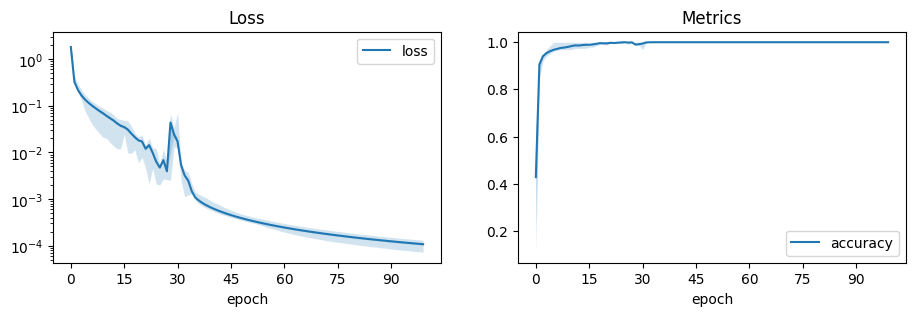

In [15]:
tot.plot_train_history(history)

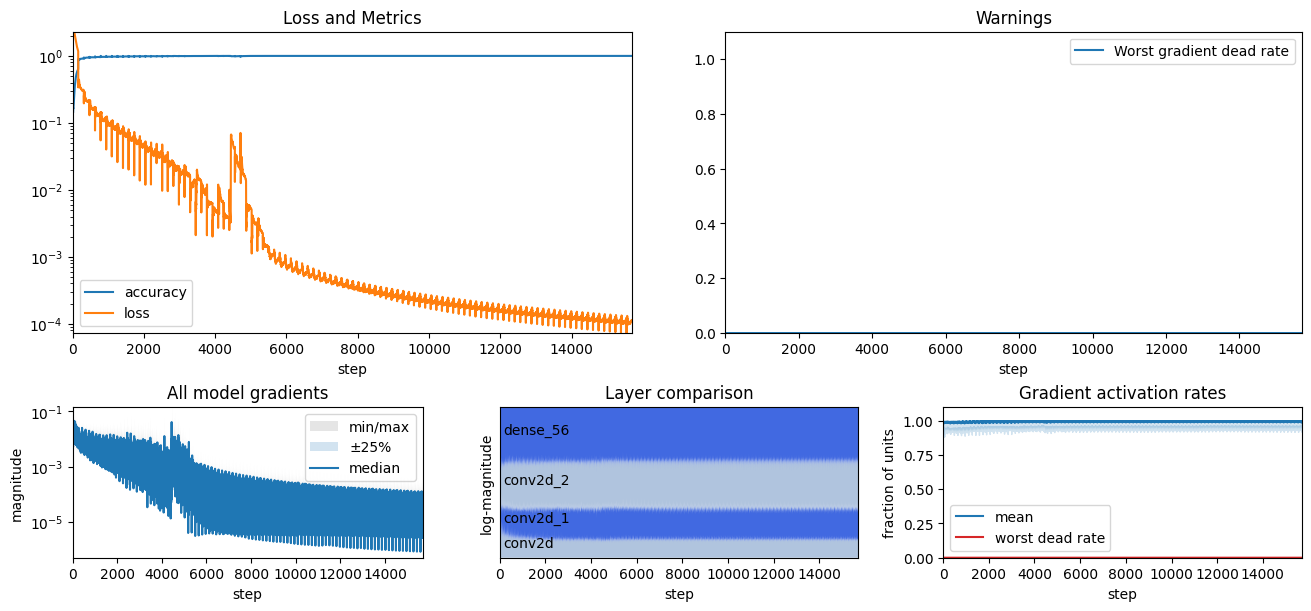

In [14]:
tot.plot_history_overview(callbacks=[gradients, history])

data shape: (100, 3, 3, 32, 32)


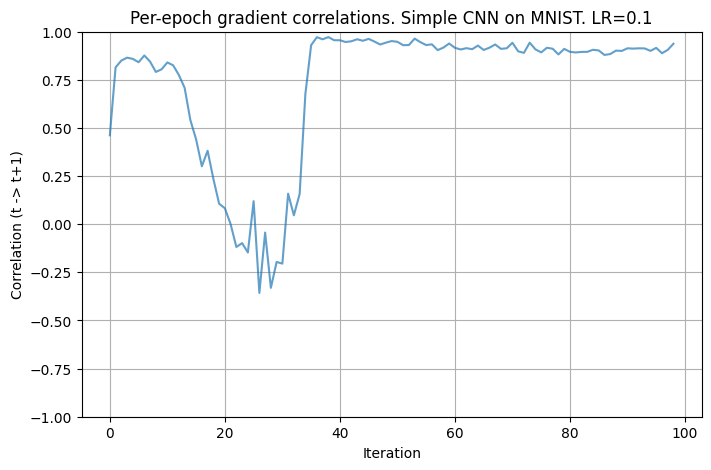

In [16]:
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
plot_correlation_trends(data, title="Per-epoch gradient correlations. Simple CNN on MNIST. LR=0.1")

data shape: (15700, 3, 3, 32, 32)


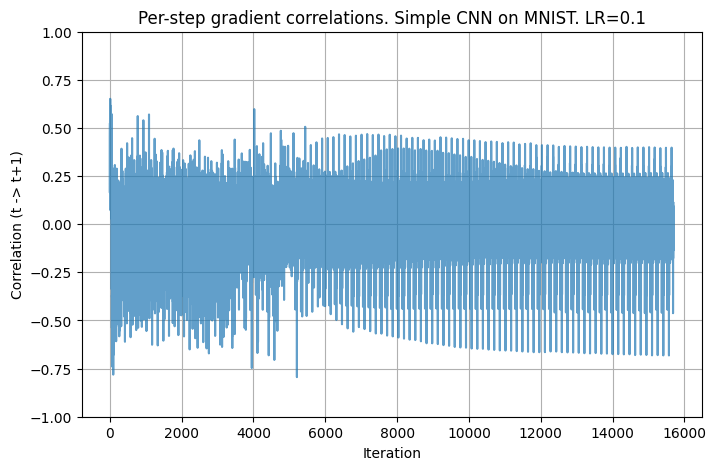

In [53]:
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
print(f"data shape: {data.shape}")
plot_correlation_trends(data, title="Per-step gradient correlations. Simple CNN on MNIST. LR=0.1")

data shape: (15700, 3, 3, 32, 32)


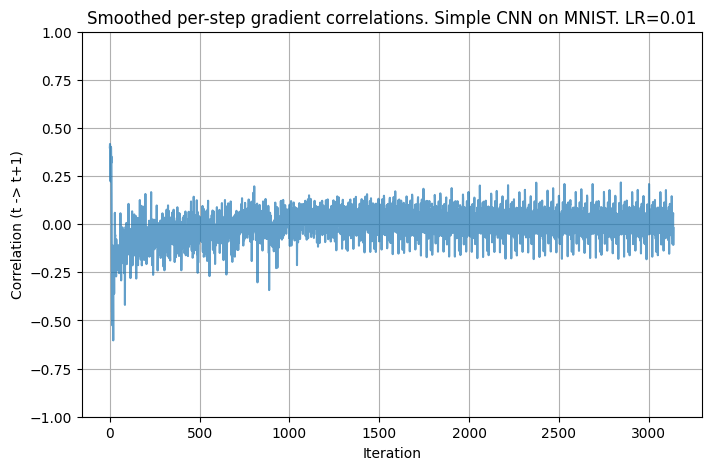

In [57]:
# attempt to emulate per-epoch correlations by smoothing the per-epoch results
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
print(f"data shape: {data.shape}")
plot_correlation_trends(data, mean_window_size=5, title="Smoothed per-step gradient correlations. Simple CNN on MNIST. LR=0.01")

data shape: (15700, 3, 3, 32, 32)


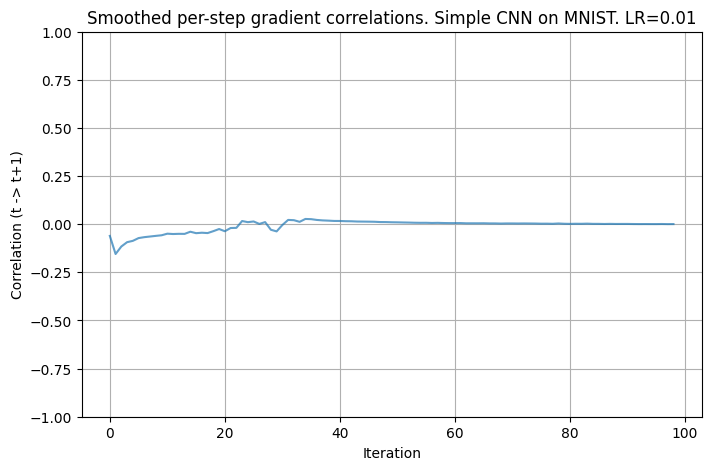

In [56]:
# attempt to emulate per-epoch correlations by smoothing the per-epoch results
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
print(f"data shape: {data.shape}")
plot_correlation_trends(data, mean_window_size=157, title="Smoothed per-step gradient correlations. Simple CNN on MNIST. LR=0.01")

**Pearson coeff with bounds**: let's try constructing an extended version of the per-epoch gradient correlations plot. This one considers the fact that the overall coefficient is really just an average or sum over the individual element-wise correlations. So let's use that to identify the range of correlations on the plot, in the hope that it'll give more of a "heads up" when things are going to turn bad.

In [84]:
# first, we prove the basic maths
def pearson_corr(x, y):
    x_mean = np.sum(x) / x.size
    y_mean = np.sum(y) / y.size

    x_diff = x - x_mean
    y_diff = y - y_mean

    # compute correlation coefficient
    numerator = np.sum(x_diff * y_diff)
    denominator = np.sqrt(np.sum(x_diff**2)) * np.sqrt(np.sum(y_diff**2))
    r = numerator / denominator

    # compute element-wise correlation contributions
    numerator = x_diff * y_diff
    scale = np.sqrt(np.sum(x_diff**2)) * np.sqrt(np.sum(y_diff**2))
    factors = (numerator / scale) * x.size
    return r, factors

layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
data = data.reshape(data.shape[0], -1)

r, factors = pearson_corr(data[0], data[1])
print(f"scipy result: {pearsonr(data[0], data[1])}")
print(f"my result: r={r}, factors={factors.shape}={np.percentile(factors, [0, 25, 50, 75, 100])}, factors.mean: {np.mean(factors)}")

scipy result: PearsonRResult(statistic=0.4618990782489231, pvalue=0.0)
my result: r=0.4618991017341614, factors=(9216,)=[-2.01943321e+01 -7.90890958e-03  1.72955533e-02  3.05994511e-01
  5.45641174e+01], factors.mean: 0.46189913153648376


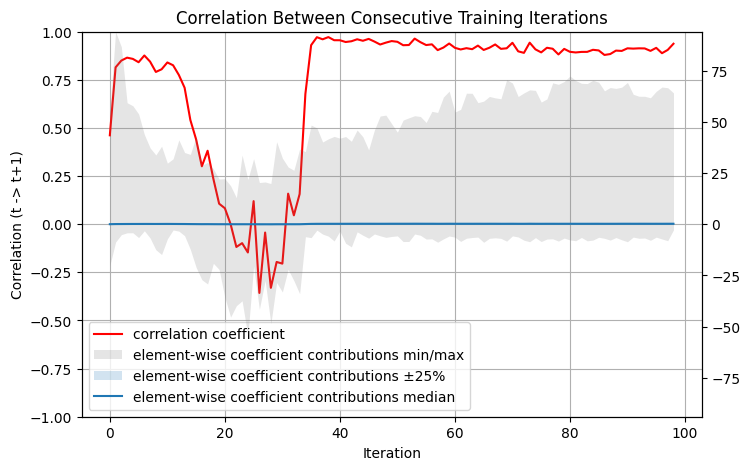

In [136]:
# now compute over whole sequence and plot with the percentiles
def plot_correlation_trends2(data, title="Correlation Between Consecutive Training Iterations", ranges_mod_func=None, ranges_scale='linear'):
  data = data.reshape(data.shape[0], -1)
  step = data.shape[0]  # Number of training steps

  # Compute correlation between consecutive steps
  # using: from scipy.stats import pearsonr
  correlations = []
  ranges = []
  q = [0, 25, 50, 75, 100]
  for i in range(step-1):
    r, factors = pearson_corr(data[i], data[i+1])
    if ranges_scale == 'log':
      factors = np.abs(factors)
    correlations.append(r)
    ranges.append(np.percentile(factors, q))

  # Convert to NumPy array for further analysis
  correlations = np.array(correlations)
  ranges = np.stack(ranges, axis=0)
  ranges = pd.DataFrame(ranges, columns=q)
  x = list(range(0, step-1))

  if ranges_mod_func:
    #ranges = ranges.iloc[:, 1:-1]  # drop first and last columns
    ranges = ranges_mod_func(ranges)

  # Plot correlation trends over iterations
  mx = np.max(np.abs(ranges))
  plt.figure(figsize=(8, 5))
  plt.title(title)
  plt.xlabel("Iteration")
  plt.ylabel("Correlation (t -> t+1)")
  plt.plot(correlations, color="r", label='correlation coefficient')
  plt.grid(True)
  plt.ylim([-1., 1.])
  ax1=plt.gca()
  ax2 = ax1.twinx()
  if ranges_scale == 'log':
    ax2.set_yscale('log')
  else:
    ax2.set_ylim([-mx, +mx])
  tot._plot_add_quantiles(x, ranges, label='element-wise coefficient contributions')

  # show legend (simple plt.legend() just shows only legends from the current axis)
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

  plt.show()
  return ranges

layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
r = plot_correlation_trends2(data)

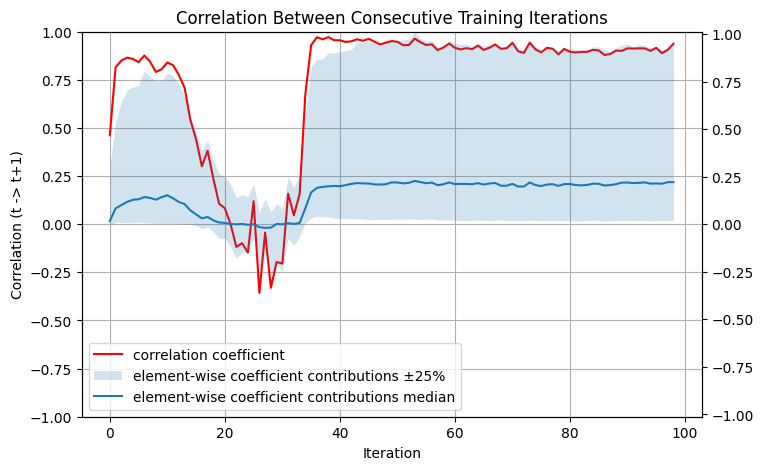

In [131]:
# dropping 0th and 100th percentiles on ranges
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
r = plot_correlation_trends2(data, ranges_mod_func=lambda ranges: ranges.iloc[:, 1:-1])

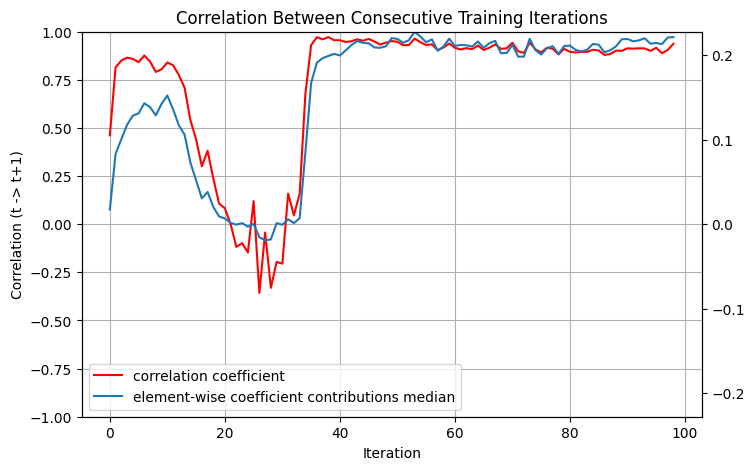

In [132]:
# showing on median from ranges
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
r = plot_correlation_trends2(data, ranges_mod_func=lambda ranges: ranges.iloc[:, 2:-2])

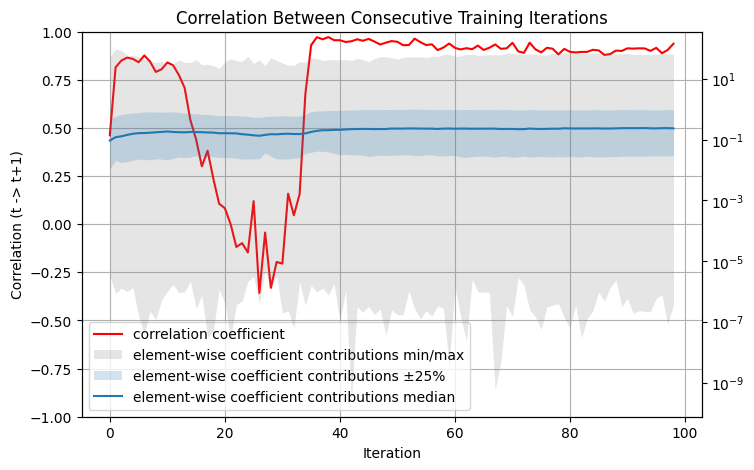

In [137]:
# applying log-abs scale to factors
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
r = plot_correlation_trends2(data, ranges_scale='log')

Conclusions:
* **The individual element-wise correlation coefficient contributions are not worth using.**
* Their distribution is a bell-like curve with an extremely sharp narrow central spike and very wide extents, making it impossible to show on a linear plot.
* I cannot use a log plot because the sign is important, and because a log plot doesn't even show anything interesting anyway due to the extreme distribution.
* Lastly, for all the variations I've looked at, the scalar coefficient (which is just the _mean_ of the element-wise coefficients) provides more meaningful information anyway.

**Pos-ratio**: Let's try the pos-ratio idea again...

In [107]:
np.max(r[100])

94.03924560546875

data shape: (100, 3, 3, 32, 32)


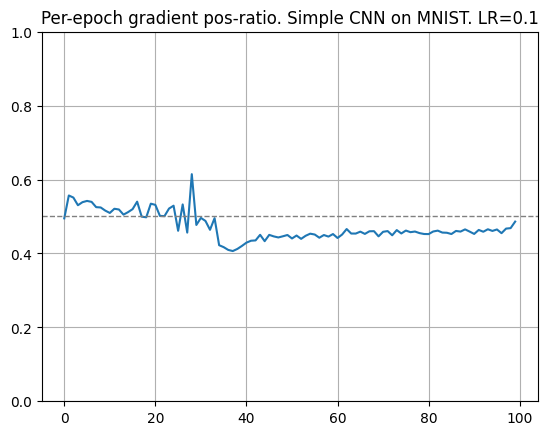

In [40]:
def pos_ratio(data):
  near_zero_threshold = np.percentile(np.abs(data), 1, axis=0)
  near_zero_threshold.shape
  pos = (data > near_zero_threshold).astype(np.float32)
  neg = (data < -near_zero_threshold).astype(np.float32)

  divisor = np.sum(pos + neg, axis=tuple(range(1,pos.ndim)))
  rates = np.sum(pos, axis=tuple(range(1,pos.ndim))) / np.maximum(1.0, divisor)
  return rates

def plot_pos_ratio(data, title="Pos ratio"):
  rates = pos_ratio(data)
  plt.plot(rates)
  plt.ylim([0., 1.])
  plt.grid()
  plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
  plt.title(title)
  plt.show()

layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
plot_pos_ratio(data, title="Per-epoch gradient pos-ratio. Simple CNN on MNIST. LR=0.1")

data shape: (15700, 3, 3, 32, 32)


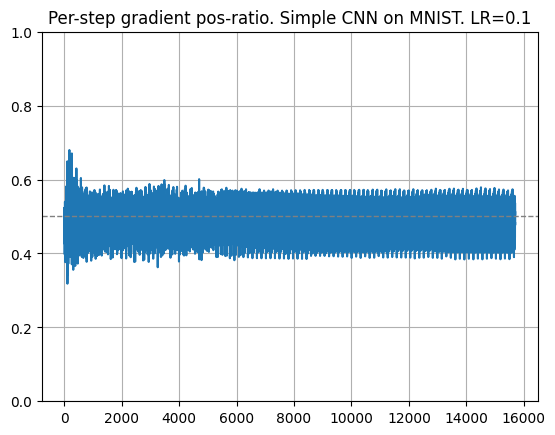

In [41]:
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
#data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
plot_pos_ratio(data, title="Per-step gradient pos-ratio. Simple CNN on MNIST. LR=0.1")

So we can't get meaningful information at the per-step level. There's just too much noise from the natural oscillations that occur through batched stochastic gradient descent.
Perhaps we can get a measure of the "goodness" of that natural per-step oscillation by looking at the size of the swings relative to the previous epoch's mean gradient.

data shape: (15700, 3, 3, 32, 32)
data: (15700, 9216), ref: (15700, 9216)
swings: (15700,)


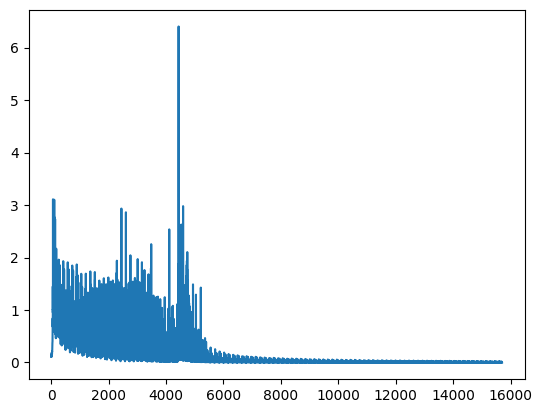

In [48]:
# first, just comparing against the mean of the current epoch, which isn't possible when doing this live.
def compute_per_step_swing(data):
  data = data.reshape(data.shape[0], -1)
  per_epoch = mean_per_window(data, window_size=157) # compute per-epoch gradients
  reference_data = np.repeat(per_epoch, repeats=157, axis=0)
  print(f"data: {data.shape}, ref: {reference_data.shape}")
  swing = np.linalg.norm(data - reference_data, axis=1)
  return swing

layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
#data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
swings = compute_per_step_swing(data)
print(f"swings: {swings.shape}")
plt.plot(swings)
plt.show()

Actually, that's really not interesting afterall. It effectively just measures how quickly or slowly the gradients are varying as the descent trajectory progresses. A more straightforward way of getting the same would be to just compare adjacent pairs of gradients.

data shape: (15700, 3, 3, 32, 32)
data: (15700, 9216), ref: (15700, 9216)
swings: (15700,)


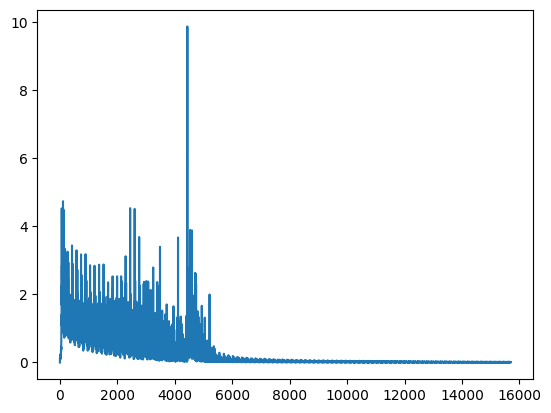

In [52]:
def compute_per_step_swing(data):
  data = data.reshape(data.shape[0], -1)
  reference_data = np.concatenate([data[0:1], data[:-1]], axis=0)  # offset by one
  print(f"data: {data.shape}, ref: {reference_data.shape}")
  swing = np.linalg.norm(data - reference_data, axis=1)
  return swing

layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
#data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
swings = compute_per_step_swing(data)
print(f"swings: {swings.shape}")
plt.plot(swings)
plt.show()

## Simple MNIST with normal learning rate

In [62]:
# Simple CNN on MNIST with normal learning rate
collection_sets=[{}]
per_step=True
gradients = tot.GradientHistoryCallback(per_step=per_step, collection_sets=collection_sets)

start = tf.timestamp()
model = mnist_simple_cnn_model(learning_rate=0.01)
train_X, train_Y = mnist_dataset()
if per_step:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(10000).batch(64)
  history = tot.fit(model, dataset, epochs=100, verbose=0, callbacks=[gradients, tot.HistoryStats(per_step=per_step), tot.LessVerboseProgressLogger()])
else:
  dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).batch(64)
  history = tot.fit(model, dataset, epochs=100, verbose=0, callbacks=[gradients, tot.HistoryStats(per_step=per_step), tot.LessVerboseProgressLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch    10 - 1.56s/epoch: accuracy: 0.9117  loss: 0.3094  
Epoch    20 - 1.44s/epoch: accuracy: 0.9429  loss: 0.2007  
Epoch    30 - 1.57s/epoch: accuracy: 0.9595  loss: 0.1436  
Epoch    40 - 1.57s/epoch: accuracy: 0.9669  loss: 0.1118  
Epoch    50 - 1.46s/epoch: accuracy: 0.9731  loss: 0.0897  
Epoch    60 - 1.38s/epoch: accuracy: 0.9789  loss: 0.0726  
Epoch    70 - 1.43s/epoch: accuracy: 0.9825  loss: 0.0589  
Epoch    80 - 1.49s/epoch: accuracy: 0.9857  loss: 0.0474  
Epoch    90 - 1.30s/epoch: accuracy: 0.9892  loss: 0.0380  
Epoch   100 - 1.43s/epoch: accuracy: 0.9926  loss: 0.0304  
Total training time: 178.74 secs


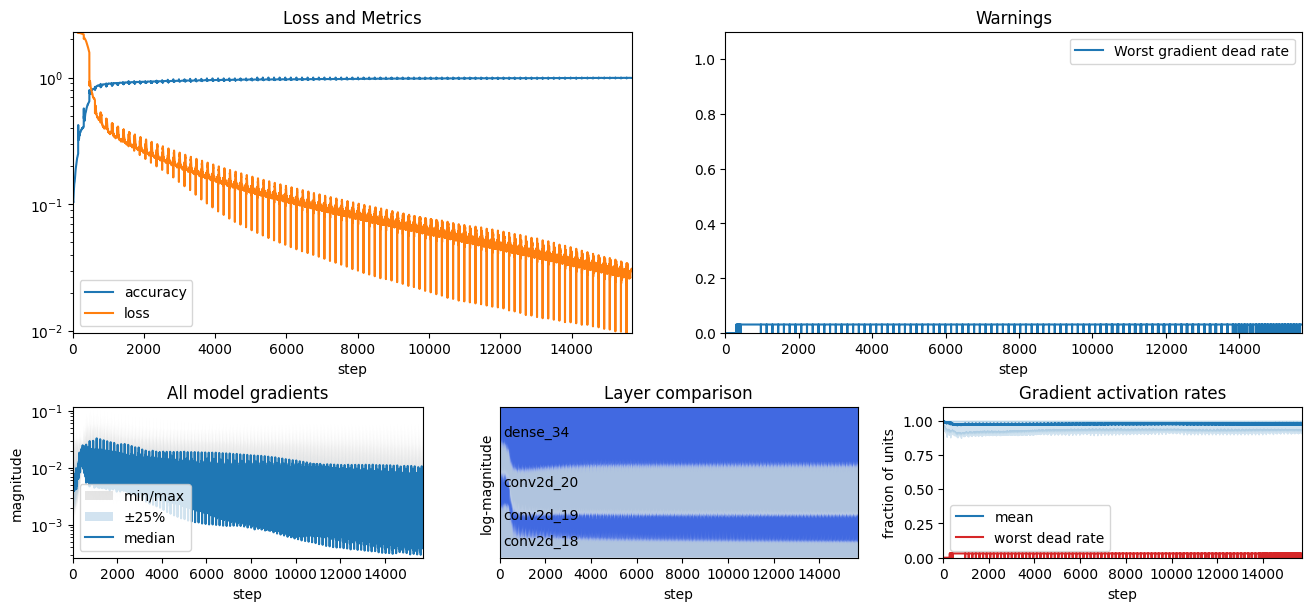

In [63]:
tot.plot_history_overview(callbacks=[gradients, history])

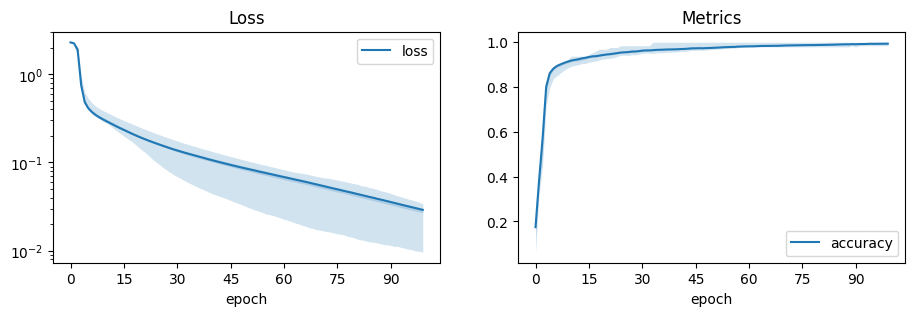

In [64]:
tot.plot_train_history(history)

data shape: (100, 3, 3, 32, 32)


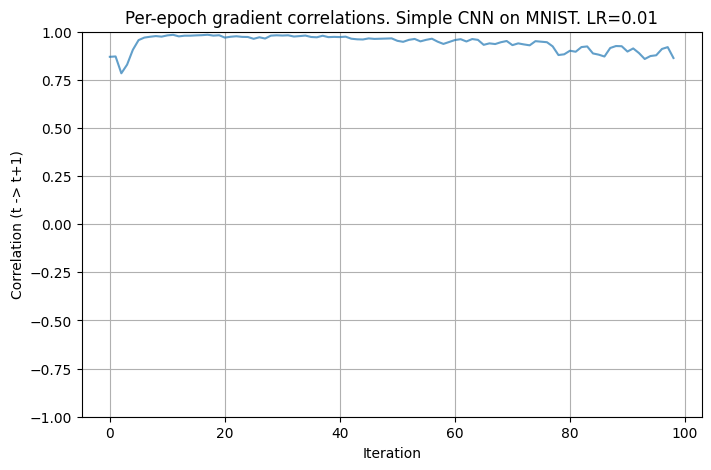

In [66]:
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
plot_correlation_trends(data, title="Per-epoch gradient correlations. Simple CNN on MNIST. LR=0.01")

data shape: (15700, 3, 3, 32, 32)


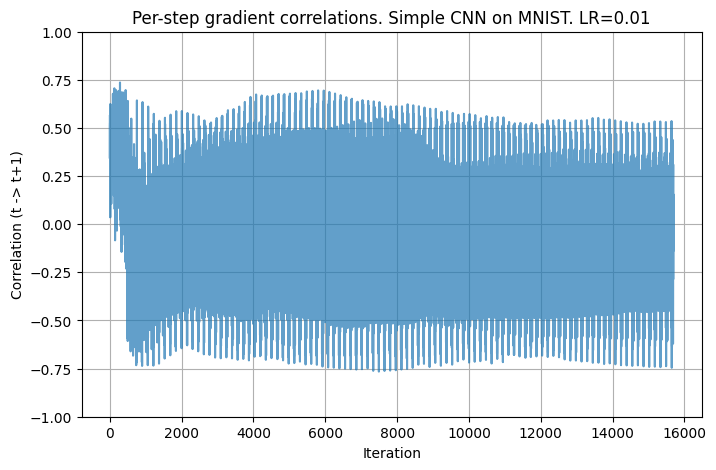

In [67]:
layer_idx = 3
var_indices = tot.variable_indices_by_layer(model)[layer_idx]
data = np.stack(gradients.gradients[var_indices[0]], axis=0)
#data = mean_per_window(data, window_size=157) # compute per-epoch gradients
print(f"data shape: {data.shape}")
plot_correlation_trends(data, title="Per-step gradient correlations. Simple CNN on MNIST. LR=0.01")

## Conclusions
Of all the things I've tried, there's only one measure that's worth implementing:
* per-epoch scalar gradient correlation coefficient

This requires that:
* per-epoch gradients are calculated as either the _sum_ or _mean_ of gradients during the epoch.